Portions of the code below have been adapted from tutorials/methods found at: 
+ https://stackabuse.com/implementing-pca-in-python-with-scikit-learn/
+ http://benalexkeen.com/scoring-classifier-models-using-scikit-learn/
+ https://stackoverflow.com/questions/19233771/sklearn-plot-confusion-matrix-with-labels
+ http://benalexkeen.com/mapping-categorical-data-in-pandas/


In [1]:
#IMPORT NECCESSSARY LIBRARIES AND PACKAGES

import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix  
from sklearn.metrics import accuracy_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
import numpy as np
from sklearn.svm import SVC  

import numpy as np
from scipy import interp
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold


# DISABLE WARNINGS
import warnings
warnings.filterwarnings('ignore')

In [2]:
#hourly data from LaGuardia Airport (LGA) data from 2/28/19 - 3/26/19
#obtained via wunderground.com historical weather portal
# shifted +12 hours .. (i.e. midnight weather will join with Noon waiting data)

weather = pd.read_csv("KLGA-NOAA - Data-KLGA-NOAA.csv") 

#hourly data for 14 hospitals data from 2/28/19 - 3/26/19
#obtained by scraping the Northwell Health Emergency Room waiting time webpage

waits = pd.read_csv("Waiting Times to Feb28April5 - Data.csv") 


In [3]:
weather.dtypes

date_time                     object
Date                          object
Time                          object
HourlyAltimeterSetting       float64
HourlyDewPointTemperature    float64
HourlyDryBulbTemperature      object
HourlyPrecipitation           object
HourlyPresentWeatherType      object
FG                             int64
DZ                             int64
BR                             int64
SN                             int64
RA                             int64
PL                             int64
TS                             int64
WeatherTypeReported            int64
HourlyRelativeHumidity       float64
HourlySeaLevelPressure       float64
HourlySkyConditions           object
CLR                            int64
FEW                            int64
SCT                            int64
BKN                            int64
OVC                            int64
VV                             int64
CloudCoverReported             int64
HourlyStationPressure        float64
H

In [4]:
weather = weather[['date_time','HourlyAltimeterSetting','HourlyDewPointTemperature',\
                   'FG','DZ','BR','SN','RA','PL','TS','WeatherTypeReported',\
                   'HourlyRelativeHumidity','CLR','FEW','SCT','BKN','OVC','VV','CloudCoverReported',\
                   'HourlyVisibility','HourlyWindSpeed','HourlyWindGustSpeed'\
                  ]]
weather.dtypes

date_time                     object
HourlyAltimeterSetting       float64
HourlyDewPointTemperature    float64
FG                             int64
DZ                             int64
BR                             int64
SN                             int64
RA                             int64
PL                             int64
TS                             int64
WeatherTypeReported            int64
HourlyRelativeHumidity       float64
CLR                            int64
FEW                            int64
SCT                            int64
BKN                            int64
OVC                            int64
VV                             int64
CloudCoverReported             int64
HourlyVisibility             float64
HourlyWindSpeed                int64
HourlyWindGustSpeed          float64
dtype: object

In [5]:
waits.dtypes

date_time    object
wait          int64
Hospital     object
dtype: object

In [6]:
# Convert string date_times to pandas date_times
weather['date_time'] = pd.to_datetime(weather['date_time'])
waits['date_time'] = pd.to_datetime(waits['date_time'])

# Add 1 sec to the weather data to match the waiting time data
weather['date_time'] = weather['date_time'] + pd.to_timedelta(1, unit='s')

#dropna from waiting time data (2 hospitals never reported)
waits = waits.dropna()
waits = waits.reset_index(drop=True)

In [7]:
#df['DOB1'] = df['DOB'].dt.strftime('%m/%d/%Y')
weather['hour'] = weather['date_time'].dt.strftime('%H').astype(int)
weather['ampm'] = weather['date_time'].dt.strftime('%p')
weather['ampm'] = weather.ampm.astype("category").cat.codes

In [8]:
#waits = waits[waits['Hospital']=='Huntington Hospital']

In [9]:
# GroupBy Average Waiting Times across each of 14 hospitals
waiting_gb = waits.groupby('date_time')['wait'].mean().reset_index()

#Set utilization based on threshold
threshold_low = 25
threshold_high =30
waiting_gb['utilization'] = 0
waiting_gb['utilization'][waiting_gb.wait >= threshold_low] = -99
waiting_gb['utilization'][waiting_gb.wait >= threshold_high] = 1

waiting_gb = waiting_gb[waiting_gb.utilization != -99]

In [10]:
waiting_gb.utilization.value_counts()

0    308
1    306
Name: utilization, dtype: int64

In [11]:
# Merge the 2 data frames on 'date_time' field
weather_wait = pd.merge(weather, waiting_gb, on='date_time')

In [12]:
# Review the current field types
weather_wait.columns

Index(['date_time', 'HourlyAltimeterSetting', 'HourlyDewPointTemperature',
       'FG', 'DZ', 'BR', 'SN', 'RA', 'PL', 'TS', 'WeatherTypeReported',
       'HourlyRelativeHumidity', 'CLR', 'FEW', 'SCT', 'BKN', 'OVC', 'VV',
       'CloudCoverReported', 'HourlyVisibility', 'HourlyWindSpeed',
       'HourlyWindGustSpeed', 'hour', 'ampm', 'wait', 'utilization'],
      dtype='object')

In [13]:
# Create a dataframe which contains the feature data
pca_data = weather_wait[[
    'HourlyAltimeterSetting', 'HourlyDewPointTemperature',
       'FG', 'DZ', 'BR', 'SN', 'RA', 'PL', 'TS', 'WeatherTypeReported',
       'HourlyRelativeHumidity', 'CLR', 'FEW', 'SCT', 'BKN', 'OVC', 'VV',
       'CloudCoverReported', 'HourlyVisibility', 'HourlyWindSpeed'
    #,
    #                   'ampm','hour'
                        ]]

# Create a dataframe which contains the target values
pca_target = weather_wait[['utilization']]

In [14]:
pca_data.FG.value_counts()

0    568
Name: FG, dtype: int64

In [15]:
data_size = pca_data['HourlyAltimeterSetting'].count()
data_size75 = int(data_size*.75)
data_size

568

In [16]:
pca_target.utilization.value_counts()

1    285
0    283
Name: utilization, dtype: int64

In [17]:
# Standardize our data and target as X, y
X = pca_data.head(data_size75)
y = pca_target.head(data_size75)
X_train = X
y_train = y

X_holdout = pca_data.tail(data_size - data_size75)
y_holdout  = pca_target.tail(data_size - data_size75)

# Perform a train/test split on our data
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.01, random_state=0)  
#X_train = X_train.reset_index()

In [18]:
# Standardize our feature data (best practice for PCA)
sc = StandardScaler()  
X_train = sc.fit_transform(X_train)  
#X_test = sc.transform(X_test)  
X_holdout = sc.fit_transform(X_holdout)

In [19]:
np.isnan(X_train)
np.where(np.isnan(X_train))
X_train = np.nan_to_num(X_train)

In [20]:
# Perform PCA and output the explained variances
#component_value=4
#pca = PCA(n_components=3)  
#X_train = pca.fit_transform(X_train)  
#X_test = pca.transform(X_test)  
#explained_variance = pca.explained_variance_ratio_  
#explained_variance

In [21]:
#https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X_train)
principalDf = pd.DataFrame(data = principalComponents
             , columns = [
                 'pc1', 'pc2'
                # ,'pc3','pc4','pc5','pc6','pc7','pc8''pc9','pc10','pc11','pc12','pc13',
                #    'pc14','pc15','pc16','pc17','pc18','pc19','pc20','pc21'
                 #,
#                          'pc22','pc23'
                         ])
explained_variance = pca.explained_variance_ratio_  
explained_variance

array([0.29443842, 0.12106458])

In [22]:
finalDf = pd.concat([principalDf, y_train], axis = 1)

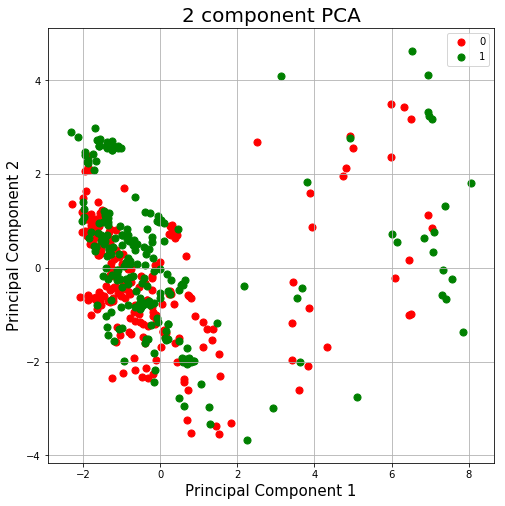

In [23]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [0, 1]
colors = ['r', 'g']
for utilization, color in zip(targets,colors):
    indicesToKeep = finalDf['utilization'] == utilization
    ax.scatter(finalDf.loc[indicesToKeep, 'pc1']
               , finalDf.loc[indicesToKeep, 'pc2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [24]:
y_holdout['utilization'].value_counts()

1    78
0    64
Name: utilization, dtype: int64

In [25]:
y_train['utilization'].value_counts()

0    219
1    207
Name: utilization, dtype: int64

The 1st 4 components represent about 75% of the variance. (0.23, 0.20, 0.13, 0.10)

In [26]:
# Setup our Random Forest classifier and run a prediction to determine best depth

for i in range(0,20,1):
  classifier = RandomForestClassifier(max_depth=i+1, random_state=0)  
  classifier.fit(X_train, y_train)
# Predicting the Test set results
  y_pred = classifier.predict(X_holdout) 
  print(i+1, accuracy_score(y_holdout, y_pred))

1 0.5633802816901409
2 0.6056338028169014
3 0.5422535211267606
4 0.5211267605633803
5 0.6619718309859155
6 0.5915492957746479
7 0.6126760563380281
8 0.6197183098591549
9 0.5633802816901409
10 0.5985915492957746
11 0.5211267605633803
12 0.6338028169014085
13 0.5633802816901409
14 0.6056338028169014
15 0.6267605633802817
16 0.6126760563380281
17 0.5915492957746479
18 0.6056338028169014
19 0.6197183098591549
20 0.5915492957746479


In [27]:
# Setup our Random Forest classifier with our best depth (2)

rclassifier = RandomForestClassifier(max_depth=2, random_state=0)  
rclassifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = rclassifier.predict(X_holdout) 

# Create a confusion matrix to illustrate our results
cm_rf = confusion_matrix(y_holdout, y_pred)  
print(cm_rf)  

# Print our accuracy score
print('Accuracy')  
print(accuracy_score(y_holdout, y_pred))
print(classification_report(y_holdout, y_pred))

[[45 19]
 [37 41]]
Accuracy
0.6056338028169014
              precision    recall  f1-score   support

           0       0.55      0.70      0.62        64
           1       0.68      0.53      0.59        78

   micro avg       0.61      0.61      0.61       142
   macro avg       0.62      0.61      0.61       142
weighted avg       0.62      0.61      0.60       142



In [28]:
# Set up our KNN classifier and run predictions to determine optimal neighbors
for i in range(1, 20):  
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_holdout)
    print(i, accuracy_score(y_holdout, y_pred))

1 0.528169014084507
2 0.5563380281690141
3 0.6056338028169014
4 0.5915492957746479
5 0.5633802816901409
6 0.5774647887323944
7 0.5915492957746479
8 0.6408450704225352
9 0.6338028169014085
10 0.6549295774647887
11 0.647887323943662
12 0.6549295774647887
13 0.676056338028169
14 0.6619718309859155
15 0.6690140845070423
16 0.6408450704225352
17 0.6619718309859155
18 0.6197183098591549
19 0.6267605633802817


In [29]:
# Setup our KNN classifier and run a prediction based on our best neighbors (7)

kclassifier = KNeighborsClassifier(n_neighbors=13)  
kclassifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = kclassifier.predict(X_holdout) 

# Create a confusion matrix to illustrate our results
cm_knn = confusion_matrix(y_holdout, y_pred)  
print(cm_knn)  

# Print our accuracy score
print('Accuracy')  
print(accuracy_score(y_holdout, y_pred))
print(classification_report(y_holdout, y_pred))

[[48 16]
 [30 48]]
Accuracy
0.676056338028169
              precision    recall  f1-score   support

           0       0.62      0.75      0.68        64
           1       0.75      0.62      0.68        78

   micro avg       0.68      0.68      0.68       142
   macro avg       0.68      0.68      0.68       142
weighted avg       0.69      0.68      0.68       142



In [30]:
# Setup our SVM classifier and run a prediction using 'rbf' kernel

svclassifier = SVC(kernel='linear')  
svclassifier.fit(X_train, y_train) 
y_pred = svclassifier.predict(X_holdout)  
# Create a confusion matrix to illustrate our results
cm_svm = confusion_matrix(y_holdout, y_pred)  
print(cm_svm)  

# Print our accuracy score
print('Accuracy')  
print(accuracy_score(y_holdout, y_pred))
print(classification_report(y_holdout, y_pred))

[[41 23]
 [30 48]]
Accuracy
0.6267605633802817
              precision    recall  f1-score   support

           0       0.58      0.64      0.61        64
           1       0.68      0.62      0.64        78

   micro avg       0.63      0.63      0.63       142
   macro avg       0.63      0.63      0.63       142
weighted avg       0.63      0.63      0.63       142



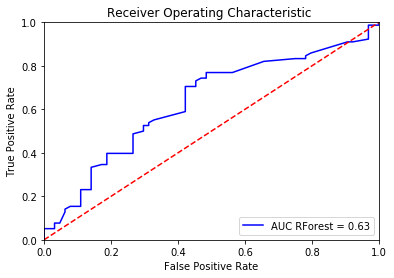

In [31]:
X = pca_data
y = pca_target
random_state = 12
#X, y = X[y], y[y]
n_samples, n_features = X.shape


# #############################################################################
# Classification and ROC analysis

# Run classifier with cross-validation and plot ROC curves

import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification


#Random Forrest 
probs = rclassifier.predict_proba(X_holdout)
preds = probs[:,1]
fpr, tpr, threshold1 = metrics.roc_curve(y_holdout, preds)
roc_auc = metrics.auc(fpr, tpr)




# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic ')
plt.plot(fpr, tpr, 'b', label = 'AUC RForest = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Accuracy of .83 is pretty good!

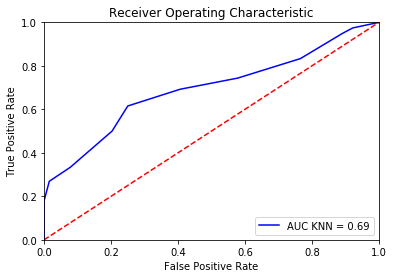

In [32]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification


#KNN
probs = kclassifier.predict_proba(X_holdout)
preds = probs[:,1]
fpr, tpr, threshold1 = metrics.roc_curve(y_holdout, preds)
roc_auc = metrics.auc(fpr, tpr)




# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC KNN = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

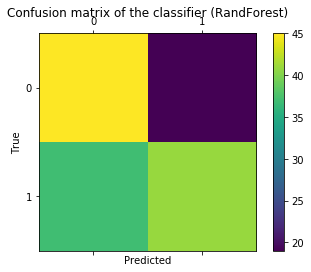

In [33]:
# Create pretty plot of confusion matrix

labels = ['0', '1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm_rf)
plt.title('Confusion matrix of the classifier (RandForest)')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

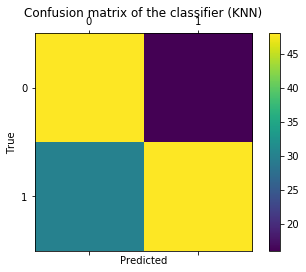

In [34]:
# Create pretty plot of confusion matrix

labels = ['0', '1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm_knn)
plt.title('Confusion matrix of the classifier (KNN)')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

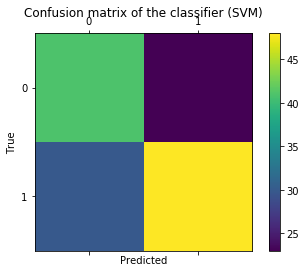

In [35]:
# Create pretty plot of confusion matrix

labels = ['0', '1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm_svm)
plt.title('Confusion matrix of the classifier (SVM)')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()